In [24]:
from catboost import CatBoostRegressor
from prophet import Prophet
import optuna
from optuna.integration import CatBoostPruningCallback
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

import warnings
warnings.simplefilter("ignore")

import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

RANDOM_SEED = 2

EDA


In [25]:
cwd = os.getcwd()
DATA_DIR = os.path.join(cwd, '..', 'data')
PROC_DATA_DIR = os.path.join(cwd, '..', 'data', 'processed')
INT_DATA_DIR = os.path.join(cwd, '..', 'data', 'interim')
RAW_DATA_DIR = os.path.join(cwd, '..', 'data', 'raw')

In [26]:
def load_data():
    """Load all required CSV files"""
    consumptions = pd.read_csv(os.path.join(RAW_DATA_DIR,'average_consumption.csv'))
    consumptions['validfrom'] = pd.to_datetime(consumptions['validfrom'])
    consumptions = consumptions.sort_values(by=["validfrom"])
    
    return consumptions

In [27]:
df_basic = load_data()

In [28]:
df_basic.head(3)

,avg,validfrom,air_temp,azimuth,cloud_opacity,dewpoint_temp,dhi,dni,ghi,gti,...,relative_humidity,snow_depth,snow_soiling_rooftop,snow_soiling_ground,wind_direction_100m,wind_direction_10m,wind_speed_100m,wind_speed_10m,zenith,price
0,0.478159,2024-01-01 00:00:00+00:00,2.86,-33.056371,79.144556,2.0,0.0,0.0,0.0,0.0,...,91.815135,3.37,7.192278,5.263320,280.044015,274.067954,6.249884,3.326795,151.919691,0.01
1,0.487376,2024-01-01 00:15:00+00:00,2.90,-39.450193,78.138996,2.0,0.0,0.0,0.0,0.0,...,91.925483,3.37,7.264865,5.227799,280.312741,274.007722,6.253359,3.357220,150.537452,0.01
2,0.478889,2024-01-01 00:30:00+00:00,2.96,-45.406950,76.868958,2.0,0.0,0.0,0.0,0.0,...,92.075985,3.32,7.145174,5.183012,280.753668,273.718147,6.255521,3.380077,148.705019,0.01


In [29]:
df_basic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23418 entries, 0 to 23417
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   avg                   23418 non-null  float64            
 1   validfrom             23418 non-null  datetime64[ns, UTC]
 2   air_temp              23418 non-null  float64            
 3   azimuth               23418 non-null  float64            
 4   cloud_opacity         23418 non-null  float64            
 5   dewpoint_temp         23418 non-null  float64            
 6   dhi                   23418 non-null  float64            
 7   dni                   23418 non-null  float64            
 8   ghi                   23418 non-null  float64            
 9   gti                   23418 non-null  float64            
 10  precipitable_water    23418 non-null  float64            
 11  precipitation_rate    23418 non-null  float64            
 12  rela

In [30]:
df_basic.describe().T

,count,mean,std,min,25%,50%,75%,max
avg,23418.0,0.171364,0.096645,0.060620,0.112156,0.142059,0.192680,0.817591
air_temp,23418.0,13.133566,8.383207,-8.130000,6.456250,13.314500,19.595750,32.131000
azimuth,23418.0,-0.043619,97.299922,-178.205091,-84.813544,0.122008,84.850000,174.220849
cloud_opacity,23418.0,34.322200,23.347651,0.000000,14.226737,32.430000,51.458250,92.053309
dewpoint_temp,23418.0,7.585435,6.949864,-13.000000,2.148250,8.149000,13.868750,20.360000
dhi,23418.0,75.061219,93.659334,0.000000,0.000000,24.217000,134.293750,445.679000
dni,23418.0,167.700390,252.632580,0.000000,0.000000,0.710500,288.032500,954.525000
ghi,23418.0,174.220261,239.739432,0.000000,0.000000,26.862000,298.621500,913.819000
gti,23418.0,192.480768,270.080271,0.000000,0.000000,25.170000,331.227250,1024.830000
precipitable_water,23418.0,21.121664,10.023891,3.206486,12.885500,19.078500,28.816500,47.443000


In [31]:
df_basic.isnull().sum()

avg                     0
validfrom               0
air_temp                0
azimuth                 0
cloud_opacity           0
dewpoint_temp           0
dhi                     0
dni                     0
ghi                     0
gti                     0
precipitable_water      0
precipitation_rate      0
relative_humidity       0
snow_depth              0
snow_soiling_rooftop    0
snow_soiling_ground     0
wind_direction_100m     0
wind_direction_10m      0
wind_speed_100m         0
wind_speed_10m          0
zenith                  0
price                   0
dtype: int64

In [32]:
import pandas as pd
import holidays

def add_calendar_features_with_holidays(df, time_col='validfrom', country='AT'):
    """
    Adds categorical calendar feature columns and identifies holidays based on the country.
    """
    df[time_col] = pd.to_datetime(df[time_col])
    
    # Add time-based categorical features
    df['hour'] = df[time_col].dt.hour              
    df['day_of_week'] = df[time_col].dt.dayofweek  
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)  
    df['day_of_month'] = df[time_col].dt.day       
    df['month'] = df[time_col].dt.month             
    df['quarter'] = df[time_col].dt.quarter        
    df['week_of_year'] = df[time_col].dt.isocalendar().week
    df["year"] = df[time_col].dt.year
    
    # Add holiday indicator
    holiday_calendar = holidays.CountryHoliday(country, years=df["year"].unique())
    df['is_holiday'] = df[time_col].dt.date.isin(holiday_calendar.keys()).astype(int)
    
    return df


In [33]:
df_basic = add_calendar_features_with_holidays(df_basic)

In [34]:
df_basic

,avg,validfrom,air_temp,azimuth,cloud_opacity,dewpoint_temp,dhi,dni,ghi,gti,...,price,hour,day_of_week,is_weekend,day_of_month,month,quarter,week_of_year,year,is_holiday
0,0.478159,2024-01-01 00:00:00+00:00,2.860,-33.056371,79.144556,2.000,0.0,0.0,0.0,0.0,...,0.01,0,0,0,1,1,1,1,2024,1
1,0.487376,2024-01-01 00:15:00+00:00,2.900,-39.450193,78.138996,2.000,0.0,0.0,0.0,0.0,...,0.01,0,0,0,1,1,1,1,2024,1
2,0.478889,2024-01-01 00:30:00+00:00,2.960,-45.406950,76.868958,2.000,0.0,0.0,0.0,0.0,...,0.01,0,0,0,1,1,1,1,2024,1
3,0.481105,2024-01-01 00:45:00+00:00,3.010,-50.913514,77.183012,2.000,0.0,0.0,0.0,0.0,...,0.01,0,0,0,1,1,1,1,2024,1
4,0.495708,2024-01-01 01:00:00+00:00,3.010,-55.932046,79.121699,2.000,0.0,0.0,0.0,0.0,...,0.02,1,0,0,1,1,1,1,2024,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23413,0.077549,2024-08-31 22:45:00+00:00,20.868,2.293000,31.549000,15.549,0.0,0.0,0.0,0.0,...,94.78,22,5,1,31,8,3,35,2024,0
23414,0.084038,2024-08-31 23:00:00+00:00,20.670,-2.248000,31.555000,15.556,0.0,0.0,0.0,0.0,...,86.00,23,5,1,31,8,3,35,2024,0
23415,0.080813,2024-08-31 23:15:00+00:00,20.564,-6.603000,29.781000,15.554,0.0,0.0,0.0,0.0,...,86.00,23,5,1,31,8,3,35,2024,0
23416,0.078287,2024-08-31 23:30:00+00:00,20.419,-10.998000,26.958000,15.527,0.0,0.0,0.0,0.0,...,86.00,23,5,1,31,8,3,35,2024,0


In [35]:
df_basic.columns

Index(['avg', 'validfrom', 'air_temp', 'azimuth', 'cloud_opacity',
       'dewpoint_temp', 'dhi', 'dni', 'ghi', 'gti', 'precipitable_water',
       'precipitation_rate', 'relative_humidity', 'snow_depth',
       'snow_soiling_rooftop', 'snow_soiling_ground', 'wind_direction_100m',
       'wind_direction_10m', 'wind_speed_100m', 'wind_speed_10m', 'zenith',
       'price', 'hour', 'day_of_week', 'is_weekend', 'day_of_month', 'month',
       'quarter', 'week_of_year', 'year', 'is_holiday'],
      dtype='object')

In [36]:
num_cols = ['air_temp', 'azimuth', 'cloud_opacity',
       'dewpoint_temp', 'dhi', 'dni', 'ghi', 'gti', 'precipitable_water',
       'precipitation_rate', 'relative_humidity', 'snow_depth',
       'snow_soiling_rooftop', 'snow_soiling_ground', 'wind_direction_100m',
       'wind_direction_10m', 'wind_speed_100m', 'wind_speed_10m', 'zenith',
       'price'
]

cat_cols = ['hour', 'day_of_week', 'is_weekend', 'day_of_month', 'month',
       'quarter', 'week_of_year', 'year', 'is_holiday'
]

dates = 'validfrom', 

feature_cols = num_cols + cat_cols
target_col = 'avg'

In [37]:
df_basic

,avg,validfrom,air_temp,azimuth,cloud_opacity,dewpoint_temp,dhi,dni,ghi,gti,...,price,hour,day_of_week,is_weekend,day_of_month,month,quarter,week_of_year,year,is_holiday
0,0.478159,2024-01-01 00:00:00+00:00,2.860,-33.056371,79.144556,2.000,0.0,0.0,0.0,0.0,...,0.01,0,0,0,1,1,1,1,2024,1
1,0.487376,2024-01-01 00:15:00+00:00,2.900,-39.450193,78.138996,2.000,0.0,0.0,0.0,0.0,...,0.01,0,0,0,1,1,1,1,2024,1
2,0.478889,2024-01-01 00:30:00+00:00,2.960,-45.406950,76.868958,2.000,0.0,0.0,0.0,0.0,...,0.01,0,0,0,1,1,1,1,2024,1
3,0.481105,2024-01-01 00:45:00+00:00,3.010,-50.913514,77.183012,2.000,0.0,0.0,0.0,0.0,...,0.01,0,0,0,1,1,1,1,2024,1
4,0.495708,2024-01-01 01:00:00+00:00,3.010,-55.932046,79.121699,2.000,0.0,0.0,0.0,0.0,...,0.02,1,0,0,1,1,1,1,2024,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23413,0.077549,2024-08-31 22:45:00+00:00,20.868,2.293000,31.549000,15.549,0.0,0.0,0.0,0.0,...,94.78,22,5,1,31,8,3,35,2024,0
23414,0.084038,2024-08-31 23:00:00+00:00,20.670,-2.248000,31.555000,15.556,0.0,0.0,0.0,0.0,...,86.00,23,5,1,31,8,3,35,2024,0
23415,0.080813,2024-08-31 23:15:00+00:00,20.564,-6.603000,29.781000,15.554,0.0,0.0,0.0,0.0,...,86.00,23,5,1,31,8,3,35,2024,0
23416,0.078287,2024-08-31 23:30:00+00:00,20.419,-10.998000,26.958000,15.527,0.0,0.0,0.0,0.0,...,86.00,23,5,1,31,8,3,35,2024,0


In [49]:
def ts_model(df, feature_cols, target_col, cat_cols, granularity="raw"):
    """
    Train a time series model using CatBoostRegressor and evaluate its performance.
    """
    # Ensure the date column is set as index
    df = df.copy()
    df.set_index('validfrom', inplace=True)
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    
    X[cat_cols] = X[cat_cols].astype('category')
    
    split_idx = -int(0.2 * len(df))  # Last 20% for testing
    X_train, X_test = X.iloc[:split_idx, :], X.iloc[split_idx:, :]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    # Train the CatBoost model
    model = CatBoostRegressor(
        iterations=1000,
        depth=6,
        learning_rate=0.01,
        loss_function="RMSE",
        random_seed=42
    )
    model.fit(
        X_train, y_train,
        cat_features=cat_cols,
        eval_set=(X_test, y_test),
        silent=True
    )
    
    # Predict and calculate RMSE
    predictions = model.predict(X_test)
    rmse = np.round(np.sqrt(mean_squared_error(y_test, predictions)), 3)
    
    # Plot the results
    plt.figure(figsize=(16, 6))
    plt.title(f"RMSE: {rmse}")
    if granularity == "month":
        plt.plot(y_test.resample("M").mean(), label="Real")
        plt.plot(
            pd.Series(predictions, index=y_test.index).resample("M").mean(),
            label="Predicted",
            linestyle="--"
        )
    else:
        plt.plot(y_test, label="Real")
        plt.plot(pd.Series(predictions, index=y_test.index), label="Predicted", linestyle="--")
    plt.xlabel("Date")
    plt.ylabel(target_col)
    plt.legend()
    plt.grid()
    plt.show()
    
    # Feature Importance
    df_importance = pd.DataFrame(
        {"feature": feature_cols, "importance": model.get_feature_importance()}
    ).sort_values(by="importance", ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x="importance", y="feature", data=df_importance)
    plt.title("Feature Importances", fontsize=16)
    plt.grid()
    plt.show()
    
    return model, predictions


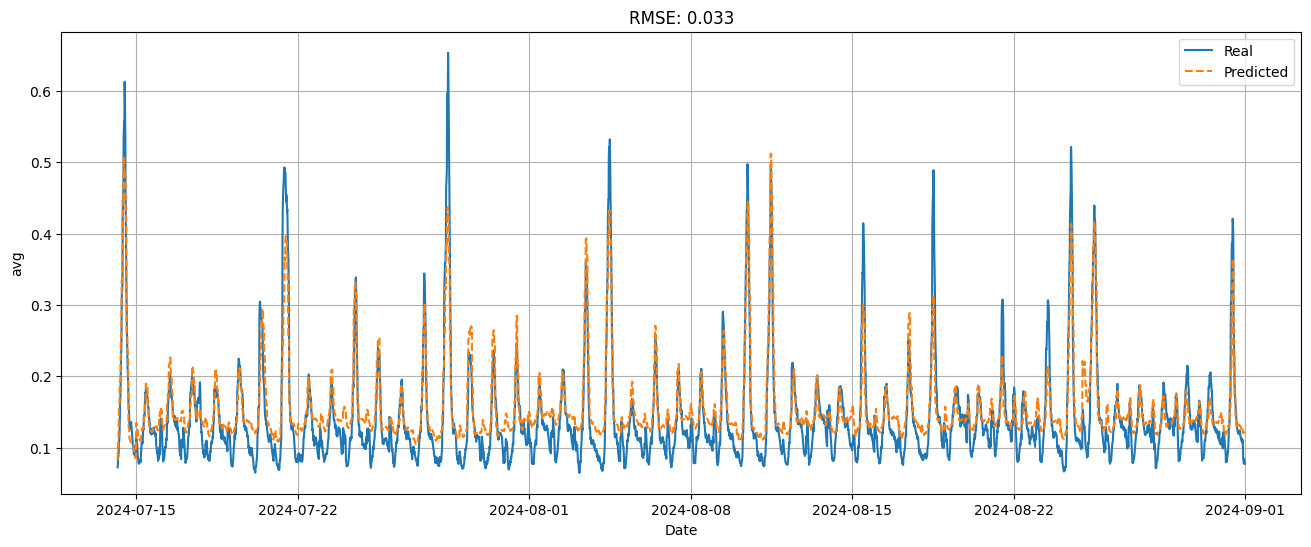

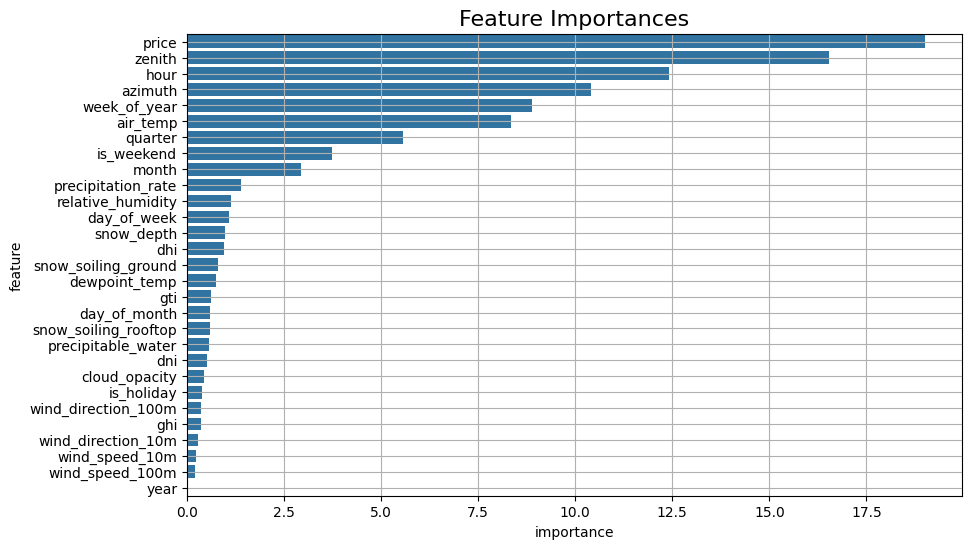

In [50]:
# Train the model and forecast
results, predictions = ts_model(
    df=df_basic,
    feature_cols=feature_cols,
    target_col=target_col,
    cat_cols=cat_cols,
    granularity="raw"
)


In [51]:
predictions

array([0.08267485, 0.10071876, 0.1043557 , ..., 0.12119485, 0.12085619,
       0.12029601])

## TODO

- [ ] Write function for forecast feature array
- [ ] Create forecast
- [ ]Check the Area Percentage Error